# Introducción práctica a Imágenes Satelitales con NDVI (Sentinel-2)

**Objetivo:** aprender a cargar bandas multiespectrales (B4 y B8), calcular el NDVI, visualizar resultados, obtener estadísticas básicas, y guardar el resultado a GeoTIFF.

## 1) Importaciones y rutas de datos
Modifique las rutas a las bandas **B4** (rojo) y **B8** (NIR). Para Sentinel-2, lo típico es trabajar con archivos `.tif` a 10 m.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
from rasterio.enums import Resampling

BASE_DIR = "data"
T1 = os.path.join(BASE_DIR, "t1")
T2 = os.path.join(BASE_DIR, "t2")

# Archivos t1
PATH_B4_T1 = os.path.join(T1, "dataS2A_B04_10m.tiff")
PATH_B8_T1 = os.path.join(T1, "dataS2A_B08_10m.tiff")
PATH_TRUE_COLOR_T1 = os.path.join(T1, "dataS2A_TRUE_COLOR.tiff")

# Archivos t2
PATH_B4_T2 = os.path.join(T2, "dataS2A_B04_2_10m.tiff")
PATH_B8_T2 = os.path.join(T2, "dataS2A_B08_2_10m.tiff")
PATH_TRUE_COLOR_T2 = os.path.join(T2, "dataS2A_TRUE_COLOR_2.tiff")

# No usar máscara de nubes
PATH_QA60 = None
PATH_SCL = None


## 2) Funciones auxiliares
- Alineación espacial y de resolución de rasters
- Cálculo de NDVI
- Máscara de nubes opcional (QA60 o SCL)


In [55]:
def read_raster(path):
    ds = rasterio.open(path)
    arr = ds.read(1)
    return ds, arr

def read_raster_rgb(path):
    """Lee un raster con múltiples bandas (RGB) y devuelve el array en formato (H, W, C)."""
    ds = rasterio.open(path)
    # Lee todas las bandas y reorganiza a (H, W, C) para matplotlib
    arr = ds.read()  # Shape: (C, H, W)
    arr = np.transpose(arr, (1, 2, 0)).astype(np.float32)
    # Normaliza a 0-1 para visualización
    arr_min, arr_max = arr.min(), arr.max()
    if arr_max > arr_min:
        arr = (arr - arr_min) / (arr_max - arr_min)
    return ds, arr

def resample_to_match(src_ds, src_arr, ref_ds):
    """Resamplea src_arr (src_ds) para que coincida con la forma/proyección de ref_ds."""
    data = np.empty((1, ref_ds.height, ref_ds.width), dtype=src_arr.dtype)
    rasterio.warp.reproject(
        source=src_arr,
        destination=data[0],
        src_transform=src_ds.transform,
        src_crs=src_ds.crs,
        dst_transform=ref_ds.transform,
        dst_crs=ref_ds.crs,
        resampling=Resampling.bilinear,
    )
    return data[0]

def compute_ndvi(nir, red):
    nir = nir.astype('float32')
    red = red.astype('float32')
    num = (nir - red)
    den = (nir + red)
    with np.errstate(divide='ignore', invalid='ignore'):
        ndvi = np.where(den == 0, np.nan, num / den)
    return ndvi

def mask_clouds_qa60(qa60):
    """Devuelve una máscara booleana True para píxeles despejados (no nubes/cirros).
    Bits: 10 = clouds, 11 = cirrus."""
    # Extrae bits 10 y 11
    cloud_bit = (qa60 & (1 << 10)) != 0
    cirrus_bit = (qa60 & (1 << 11)) != 0
    clear = ~(cloud_bit | cirrus_bit)
    return clear

def mask_clouds_scl(scl):
    """Máscara booleana True = píxeles válidos (sin nubes/niebla/sombra). Basado en clases SCL Sentinel-2.
    Referencia (resumen): 0 No data; 1 Saturated/Defective; 2 Dark Area; 3 Cloud Shadows; 4 Vegetation; 5 Bare; 6 Water; 7 Unclassified;
    8 Cloud Medium; 9 Cloud High; 10 Cirrus; 11 Snow/Ice.
    Ajuste según su criterio de calidad.
    """
    bad_classes = {0,1,3,8,9,10,11}
    mask_good = ~np.isin(scl, list(bad_classes))
    return mask_good


## 3) Carga de bandas y alineación (si es necesario)
Esta celda abre las bandas B4 y B8. Si sus resoluciones/transformaciones difieren, B4 se re-muestrea a la malla de B8 (o viceversa).


In [56]:
def read_raster(path):
    ds = rasterio.open(path)
    arr = ds.read(1)
    return ds, arr


# t1
ds_b4_t1, b4_t1 = read_raster(PATH_B4_T1)
ds_b8_t1, b8_t1 = read_raster(PATH_B8_T1)

if (ds_b4_t1.width != ds_b8_t1.width) or (ds_b4_t1.height != ds_b8_t1.height):
    b4_t1 = resample_to_match(ds_b4_t1, b4_t1, ds_b8_t1)

# t2
ds_b4_t2, b4_t2 = read_raster(PATH_B4_T2)
ds_b8_t2, b8_t2 = read_raster(PATH_B8_T2)

if (ds_b4_t2.width != ds_b8_t2.width) or (ds_b4_t2.height != ds_b8_t2.height):
    b4_t2 = resample_to_match(ds_b4_t2, b4_t2, ds_b8_t2)

print("t1 shapes:", b4_t1.shape, b8_t1.shape)
print("t2 shapes:", b4_t2.shape, b8_t2.shape)


t1 shapes: (105, 248) (105, 248)
t2 shapes: (105, 248) (105, 248)


## 5) Cargar máscara de nubes y generar máscara de validez
- Si se usa **QA60**: elimina nubes/cirros por bits.
- Si se usa **SCL**: conserva clases "buenas" (vegetación, suelo, agua) y filtra nubes/sombras.


In [57]:
valid_mask_t1 = None
valid_mask_t2 = None


if PATH_QA60:
    ds_q1, qa1 = read_raster(PATH_QA60)
    if (ds_q1.width != ds_b8_t1.width) or (ds_q1.height != ds_b8_t1.height):
        qa1 = resample_to_match(ds_q1, qa1, ds_b8_t1)
    valid_mask_t1 = mask_clouds_qa60(qa1)

elif PATH_SCL:
    ds_s1, scl1 = read_raster(PATH_SCL)

    # SCL normalmente está a 20 m y toca llevarlo a 10 m
    scl1_10m = np.empty((ds_b8_t1.height, ds_b8_t1.width), dtype=scl1.dtype)
    rasterio.warp.reproject(
        source=scl1,
        destination=scl1_10m,
        src_transform=ds_s1.transform,
        src_crs=ds_s1.crs,
        dst_transform=ds_b8_t1.transform,
        dst_crs=ds_b8_t1.crs,
        resampling=Resampling.nearest
    )
    valid_mask_t1 = mask_clouds_scl(scl1_10m)




if PATH_QA60:
    ds_q2, qa2 = read_raster(PATH_QA60)
    if (ds_q2.width != ds_b8_t2.width) or (ds_q2.height != ds_b8_t2.height):
        qa2 = resample_to_match(ds_q2, qa2, ds_b8_t2)
    valid_mask_t2 = mask_clouds_qa60(qa2)

elif PATH_SCL:
    ds_s2, scl2 = read_raster(PATH_SCL)

    scl2_10m = np.empty((ds_b8_t2.height, ds_b8_t2.width), dtype=scl2.dtype)
    rasterio.warp.reproject(
        source=scl2,
        destination=scl2_10m,
        src_transform=ds_s2.transform,
        src_crs=ds_s2.crs,
        dst_transform=ds_b8_t2.transform,
        dst_crs=ds_b8_t2.crs,
        resampling=Resampling.nearest
    )
    valid_mask_t2 = mask_clouds_scl(scl2_10m)

# Reporte
if valid_mask_t1 is not None:
    print("T1 máscara cargada. Proporción válida:", np.mean(valid_mask_t1))
else:
    print("T1 sin máscara de nubes. Se usa todo el ráster.")

if valid_mask_t2 is not None:
    print("T2 máscara cargada. Proporción válida:", np.mean(valid_mask_t2))
else:
    print("T2 sin máscara de nubes. Se usa todo el ráster.")


T1 sin máscara de nubes. Se usa todo el ráster.
T2 sin máscara de nubes. Se usa todo el ráster.


## 7) Cálculo de NDVI
NDVI = (NIR - Red) / (NIR + Red). Se manejan divisiones por cero como `NaN`.


In [58]:
def compute_ndvi(nir, red):
    nir = nir.astype('float32')
    red = red.astype('float32')

    num = nir - red
    den = nir + red

    with np.errstate(divide='ignore', invalid='ignore'):
        ndvi = np.where(den == 0, np.nan, num / den)

    return ndvi

ndvi_t1 = compute_ndvi(b8_t1, b4_t1)

if valid_mask_t1 is not None:
    ndvi_t1 = np.where(valid_mask_t1, ndvi_t1, np.nan)

ndvi_t1_min, ndvi_t1_max = np.nanmin(ndvi_t1), np.nanmax(ndvi_t1)
print(f"T1 NDVI rango: min={ndvi_t1_min:.3f}, max={ndvi_t1_max:.3f}")


ndvi_t2 = compute_ndvi(b8_t2, b4_t2)

if valid_mask_t2 is not None:
    ndvi_t2 = np.where(valid_mask_t2, ndvi_t2, np.nan)

ndvi_t2_min, ndvi_t2_max = np.nanmin(ndvi_t2), np.nanmax(ndvi_t2)
print(f"T2 NDVI rango: min={ndvi_t2_min:.3f}, max={ndvi_t2_max:.3f}")



T1 NDVI rango: min=-0.245, max=0.954
T2 NDVI rango: min=-0.283, max=0.978


## 7) Visualización y estadísticas básicas
- Mapa NDVI (1 figura)
- Histograma de NDVI (1 figura)
- Valores estadísticos (media, mediana, percentiles)


=== T1 ===


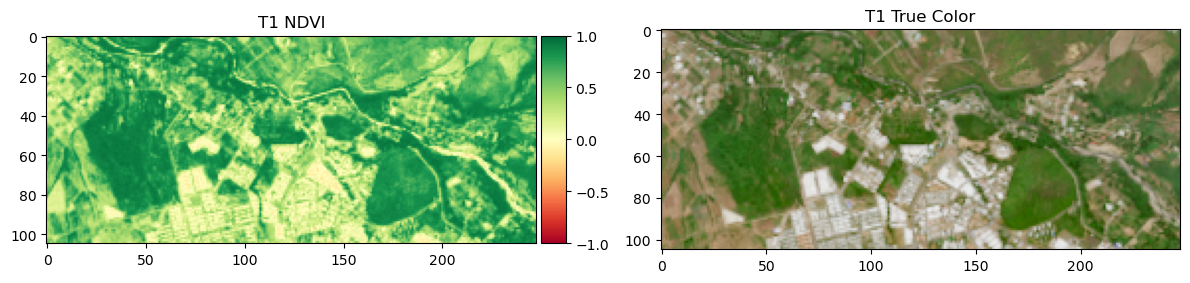

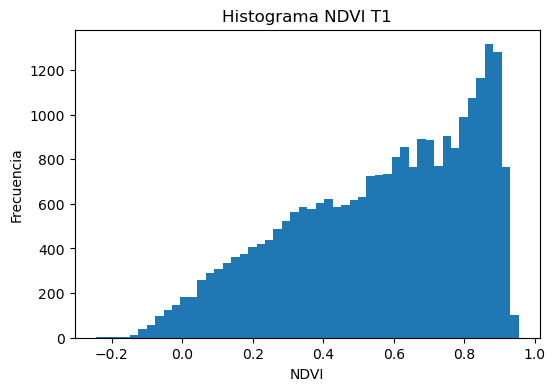

{'T1_mean': 0.5618327856063843, 'T1_median': 0.6056337952613831, 'T1_p10': 0.17555912286043168, 'T1_p90': 0.8727272748947144}

=== T2 ===


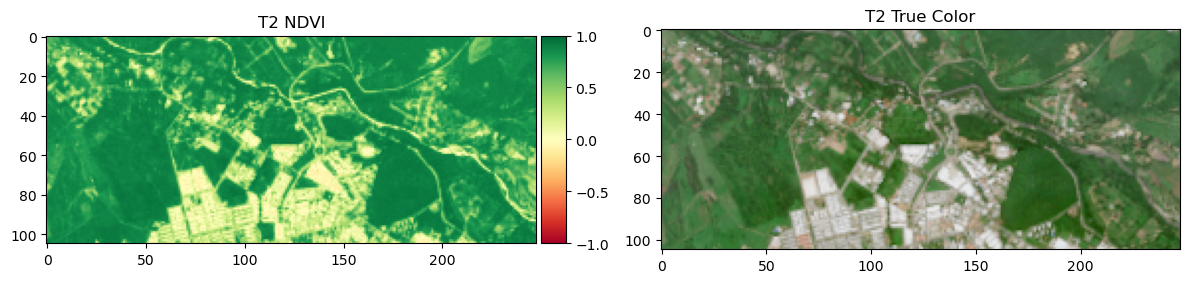

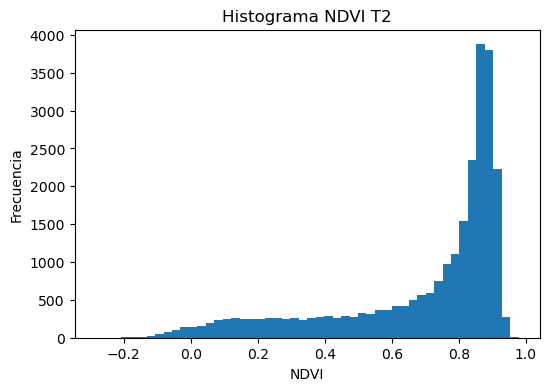

{'T2_mean': 0.695381224155426, 'T2_median': 0.8198198080062866, 'T2_p10': 0.2432432472705841, 'T2_p90': 0.9016393423080444}


In [59]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# --- Función auxiliar para cargar true color ---
def read_raster_rgb(path):
    ds = rasterio.open(path)
    # SentinelHub exporta TrueColor como RGB (3 bandas)
    img = ds.read([1, 2, 3])  # Bandas RGB
    img = np.transpose(img, (1, 2, 0))  # (filas, cols, canales)
    return ds, img

print("=== T1 ===")

_, img_t1 = read_raster_rgb(PATH_TRUE_COLOR_T1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# NDVI
im1 = ax1.imshow(ndvi_t1, cmap='RdYlGn', vmin=-1, vmax=1)
ax1.set_title("T1 NDVI")
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)

# True color
ax2.imshow(img_t1)
ax2.set_title("T1 True Color")

plt.tight_layout()
plt.show()

# Histograma T1
plt.figure(figsize=(6,4))
vals_t1 = ndvi_t1[np.isfinite(ndvi_t1)].ravel()
plt.hist(vals_t1, bins=50)
plt.title("Histograma NDVI T1")
plt.xlabel("NDVI")
plt.ylabel("Frecuencia")
plt.show()

# Estadísticas T1
mean_t1  = float(np.nanmean(ndvi_t1))
median_t1 = float(np.nanmedian(ndvi_t1))
p10_t1, p90_t1 = float(np.nanpercentile(ndvi_t1, 10)), float(np.nanpercentile(ndvi_t1, 90))

print({
    "T1_mean": mean_t1,
    "T1_median": median_t1,
    "T1_p10": p10_t1,
    "T1_p90": p90_t1
})

print("\n=== T2 ===")

_, img_t2 = read_raster_rgb(PATH_TRUE_COLOR_T2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# NDVI
im1 = ax1.imshow(ndvi_t2, cmap='RdYlGn', vmin=-1, vmax=1)
ax1.set_title("T2 NDVI")
divider2 = make_axes_locatable(ax1)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax2)

# True color
ax2.imshow(img_t2)
ax2.set_title("T2 True Color")

plt.tight_layout()
plt.show()

# Histograma T2
plt.figure(figsize=(6,4))
vals_t2 = ndvi_t2[np.isfinite(ndvi_t2)].ravel()
plt.hist(vals_t2, bins=50)
plt.title("Histograma NDVI T2")
plt.xlabel("NDVI")
plt.ylabel("Frecuencia")
plt.show()

# Estadísticas T2
mean_t2  = float(np.nanmean(ndvi_t2))
median_t2 = float(np.nanmedian(ndvi_t2))
p10_t2, p90_t2 = float(np.nanpercentile(ndvi_t2, 10)), float(np.nanpercentile(ndvi_t2, 90))

print({
    "T2_mean": mean_t2,
    "T2_median": median_t2,
    "T2_p10": p10_t2,
    "T2_p90": p90_t2
})


## 8) Guardar NDVI como GeoTIFF
El archivo se guardará con la misma proyección y transformada espacial que la banda de referencia.


In [60]:
# Crear carpeta de salida
os.makedirs("outputs", exist_ok=True)

# ---- Guardar NDVI T1 ----
out_t1 = "outputs/ndvi_t1.tif"
profile_t1 = ds_b8_t1.profile.copy()
profile_t1.update(dtype=rasterio.float32, count=1, nodata=np.nan)

with rasterio.open(out_t1, "w", **profile_t1) as dst:
    dst.write(ndvi_t1.astype("float32"), 1)

print("Guardado:", out_t1)




# ---- Guardar NDVI T2 ----
out_t2 = "outputs/ndvi_t2.tif"
profile_t2 = ds_b8_t2.profile.copy()
profile_t2.update(dtype=rasterio.float32, count=1, nodata=np.nan)

with rasterio.open(out_t2, "w", **profile_t2) as dst:
    dst.write(ndvi_t2.astype("float32"), 1)

print("Guardado:", out_t2)


Guardado: outputs/ndvi_t1.tif
Guardado: outputs/ndvi_t2.tif


## Tarea: Comparación de dos fechas y mapa de cambio
Proporcione dos pares de bandas B4/B8 (t1 y t2). El resultado será un **mapa de diferencia de NDVI** (t2 - t1).


T1: (105, 248) T2: (105, 248)


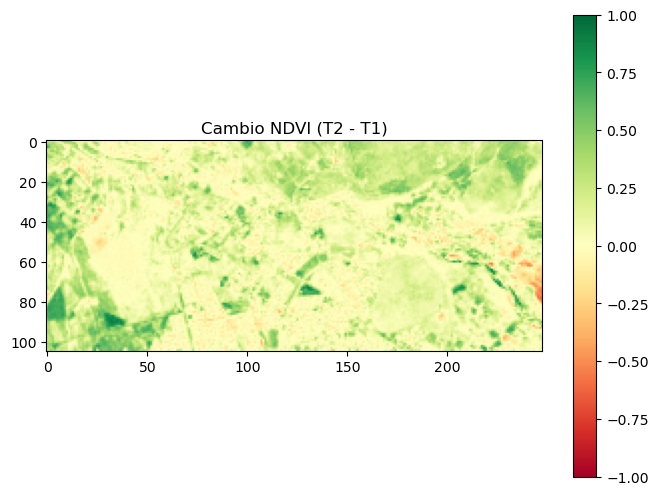

In [ ]:
# existen las dos variables
try:
    print("T1:", ndvi_t1.shape, "T2:", ndvi_t2.shape)
except:
    print("Alguna de las variables ndvi_t1 o ndvi_t2 no existe aún.")

#misma forma
if ndvi_t1.shape != ndvi_t2.shape:
    raise ValueError("Las matrices NDVI de T1 y T2 no tienen el mismo tamaño. Revisa tus pasos anteriores.")

# Diferencia 
d_ndvi = ndvi_t2 - ndvi_t1

# Graficar
plt.figure(figsize=(8,6))
plt.imshow(d_ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title('Cambio NDVI (T2 - T1)')
plt.colorbar()
plt.show()


## (Tarea opcional) Estadísticas zonales por polígonos
Calcule estadísticas de NDVI por polígonos (veredas, fincas, municipios, etc.). Requiere `geopandas` y `rasterstats`.


In [ ]:
USE_ZONAL = False  # Cambie a True si quiere ejecutar
VECTOR_PATH = 'data/zonas.gpkg'  # o .shp/.geojson

if USE_ZONAL:
    import geopandas as gpd
    from rasterstats import zonal_stats
    gdf = gpd.read_file(VECTOR_PATH)
    stats = zonal_stats(
        gdf, out_path, stats=['count','mean','median','percentile_10','percentile_90'],
        nodata=np.nan
    )
    gdf_out = gdf.copy()
    gdf_out = gdf_out.join(np.array(stats).view(np.recarray))
    gdf_out.to_file('outputs/ndvi_stats.gpkg', driver='GPKG')
    print('Guardado: outputs/ndvi_stats.gpkg')
else:
    print('Active USE_ZONAL=True y ajuste VECTOR_PATH para calcular estadísticas zonales.')
